In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
import kagglehub

2025-02-12 10:37:37.922903: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-12 10:37:38.064357: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739356658.123884    2064 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739356658.140289    2064 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-12 10:37:38.280024: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# Download the dataset
path = kagglehub.dataset_download("mohamedhanyyy/chest-ctscan-images")
print("Path to dataset files:", path)

# Define dataset paths
dataset_path = "/teamspace/studios/this_studio/.cache/kagglehub/datasets/mohamedhanyyy/chest-ctscan-images/versions/1/Data"

Path to dataset files: /teamspace/studios/this_studio/.cache/kagglehub/datasets/mohamedhanyyy/chest-ctscan-images/versions/1


In [3]:
# Parameters
img_size = (224, 224)
batch_size = 32

# Load datasets from directories
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path + "/train", 
    image_size=img_size, 
    batch_size=batch_size, 
    label_mode='categorical'
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path + "/valid", 
    image_size=img_size, 
    batch_size=batch_size, 
    label_mode='categorical'
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path + "/test", 
    image_size=img_size, 
    batch_size=batch_size, 
    label_mode='categorical'
)

Found 613 files belonging to 4 classes.
Found 72 files belonging to 4 classes.
Found 315 files belonging to 4 classes.


W0000 00:00:1739356665.936615    2064 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
# Cache and prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

num_classes = 4

In [5]:
# Define a data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [6]:
# Normalization layer: scales pixel values to [0,1]
normalization_layer = layers.Rescaling(1.0 / 255)

In [7]:
# Load the EfficientNetB0 model pre-trained on ImageNet, excluding the top layers
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # Freeze the base model during initial training

In [8]:
# Build the full model using the Functional API
inputs = layers.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)         # Apply data augmentation
x = normalization_layer(x)            # Normalize images
x = base_model(x, training=False)     # Extract features using the pre-trained model
x = layers.GlobalAveragePooling2D()(x)  # Global pooling to reduce feature maps to a vector
x = layers.Dropout(0.5)(x)            # Regularize with dropout
# Optionally, you can add more Dense layers here if needed:
# x = layers.Dense(128, activation='relu')(x)
# x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)  # Final classification layer

model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [9]:
optimizer = optimizers.Adam(learning_rate=1e-3)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:
# Define callbacks
callback_list = [
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    callbacks.ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True)
]

In [11]:
initial_epochs = 30

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=initial_epochs,
    callbacks=callback_list
)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.2768 - loss: 1.4263

20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 495ms/step - accuracy: 0.2767 - loss: 1.4260 - val_accuracy: 0.2083 - val_loss: 1.3909 - learning_rate: 0.0010
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.2688 - loss: 1.4141

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 370ms/step - accuracy: 0.2680 - loss: 1.4141 - val_accuracy: 0.3194 - val_loss: 1.3908 - learning_rate: 0.0010
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.2534 - loss: 1.3990

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 363ms/step - accuracy: 0.2542 - loss: 1.3991 - val_accuracy: 0.3194 - val_loss: 1.3863 - learning_rate: 0.0010
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 356ms/step - accuracy: 0.2725 - loss: 1.3799 - val_accuracy: 0.3194 - val_loss: 1.3881 - learning_rate: 0.0010
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 345ms/step - accuracy: 0.2677 - loss: 1.4056 - val_accuracy: 0.3194 - val_loss: 1.3915 - learning_rate: 0.0010
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.2855 - loss: 1.4040
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 343ms/step - accuracy: 0.2854 - loss: 1.4041 - val_accuracy: 0.3194 - val_loss: 1.3875 - learning_rate: 0.0010
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 378ms/step - accuracy: 0.3288 - loss: 1.3781 - val_accuracy: 0.3194 - val_loss: 1.3964 - learning_rate: 5.0000e-04
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 359ms/step - accuracy: 0.3084 - loss: 1.3787 - val_accu

In [12]:
# 5. Fine-tuning the Model
# =============================================
# Unfreeze some layers of the base model for fine-tuning
base_model.trainable = True

# Freeze the lower layers to retain low-level feature representations.
# Here, we freeze all layers before the 'fine_tune_at' layer.
fine_tune_at = 100  # adjust as needed based on model depth
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model with a lower learning rate for fine-tuning
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    callbacks=callback_list
)


Epoch 8/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - accuracy: 0.4059 - loss: 1.2703

20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 938ms/step - accuracy: 0.4084 - loss: 1.2649 - val_accuracy: 0.3194 - val_loss: 1.3811 - learning_rate: 1.0000e-04
Epoch 9/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 784ms/step - accuracy: 0.5337 - loss: 1.0605 - val_accuracy: 0.3194 - val_loss: 1.3840 - learning_rate: 1.0000e-04
Epoch 10/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5608 - loss: 1.0223 - val_accuracy: 0.3194 - val_loss: 1.3868 - learning_rate: 1.0000e-04
Epoch 11/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5652 - loss: 0.9720
Epoch 11: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.5639 - loss: 0.9728 - val_accuracy: 0.0556 - val_loss: 1.3906 - learning_rate: 1.0000e-04
Epoch 12/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 937ms/step - accuracy: 0.5755 - loss: 0.9516 - val_accuracy: 0.3194 - val_loss: 1.3888 - learning_rate: 5.0000e-05
Epoch 13/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.5925 - loss: 0.

In [13]:
# 6. Evaluate the Model
# =============================================

test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 675ms/step - accuracy: 0.3450 - loss: 1.3710
Test Accuracy: 0.3810


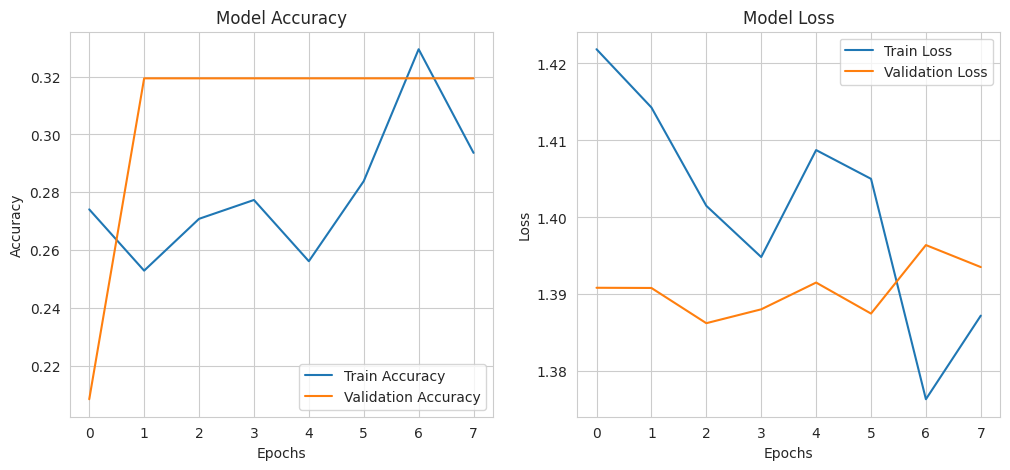

In [19]:
def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)

Found 315 files belonging to 4 classes.
 4/10 ━━━━━━━━━━━━━━━━━━━━ 3s 643ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 659ms/step


2025-02-12 10:52:00.636442: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 621ms/step - accuracy: 0.3598 - loss: 1.3687
Test Accuracy: 38.10%


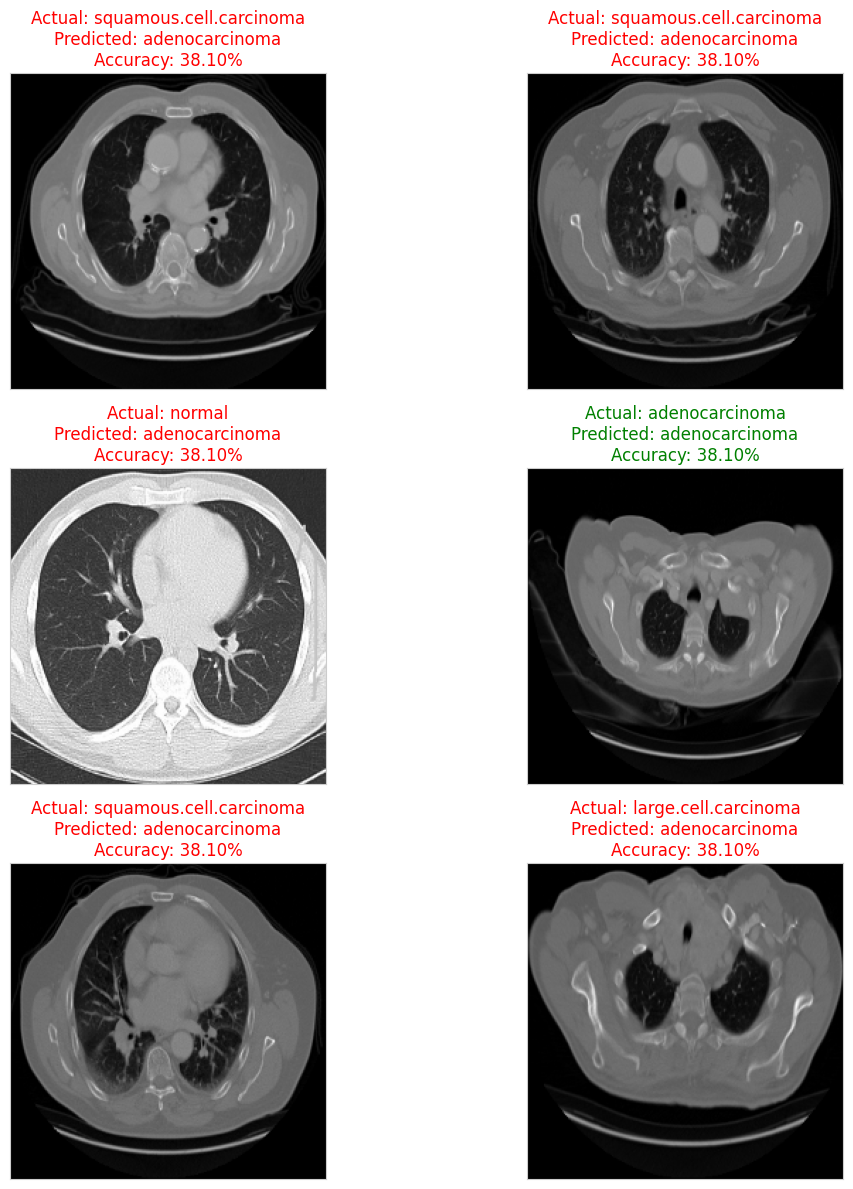

In [18]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style("whitegrid")

# -------------------------------------------------------------------
# 1. Set Dataset Parameters and Load the Raw Test Dataset
# -------------------------------------------------------------------
# Make sure these are defined as in your training code:
dataset_path = "/teamspace/studios/this_studio/.cache/kagglehub/datasets/mohamedhanyyy/chest-ctscan-images/versions/1/Data"
img_size = (224, 224)
batch_size = 32

# Load the raw test dataset (this version has the 'class_names' attribute)
test_dataset_raw = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path + "/test",
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# Save the class names for later use
class_labels = test_dataset_raw.class_names

# -------------------------------------------------------------------
# 2. Define the Normalization Layer and the `prepare` Function
# -------------------------------------------------------------------
normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False):
    ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.cache().shuffle(1000)
    return ds.cache().prefetch(buffer_size=AUTOTUNE)

# Prepare the test dataset (this version will lose the 'class_names' attribute,
# but we already stored them in `class_labels`)
test_dataset = prepare(test_dataset_raw)

# -------------------------------------------------------------------
# 3. Get Predictions on Test Data
# -------------------------------------------------------------------
# Assuming `model` is already defined and loaded (trained or loaded from file)
predictions = model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)

# -------------------------------------------------------------------
# 4. Extract True Labels and Images from the Dataset
# -------------------------------------------------------------------
# Since `test_dataset` is a tf.data.Dataset, iterate over it to collect images and labels
test_images = []
test_labels = []

for images, labels in test_dataset:
    test_images.append(images.numpy())
    test_labels.append(labels.numpy())

# Concatenate all batches into single arrays
test_images = np.concatenate(test_images, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

# Convert one-hot encoded labels to integer class indices
true_classes = np.argmax(test_labels, axis=1)

# -------------------------------------------------------------------
# 5. Evaluate the Model on Test Data
# -------------------------------------------------------------------
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# -------------------------------------------------------------------
# 6. Plot Sample Test Images with Their Predictions
# -------------------------------------------------------------------
plt.figure(figsize=(12, 12))
num_images_to_plot = 6  # Adjust the number of images to plot as desired

for i in range(num_images_to_plot):
    plt.subplot(3, 2, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    # Get the i-th image (images are already normalized to [0, 1])
    img = test_images[i]
    plt.imshow(img)

    # Get the actual and predicted labels
    actual_label = class_labels[true_classes[i]]
    predicted_label = class_labels[predicted_classes[i]]

    # Build the title string showing actual vs. predicted labels and the overall test accuracy
    title = f"Actual: {actual_label}\nPredicted: {predicted_label}\nAccuracy: {test_accuracy * 100:.2f}%"
    color = "green" if predicted_label == actual_label else "red"
    plt.title(title, color=color)

plt.tight_layout()
plt.show()
